Introduction
------------


We will analyze a microarray dataset for a set of leukemia
samples, including acute lymphoblastic leukemia (ALL) as
discussed in class.  We will use the open source statistical
analysis software package **R**, which is widely used in
bioinformatics for tasks such as microarray analysis,
because

* it can handle large datasets such as microarray expression data;
* many R "modules" have been written for specific types of analysis (e.g. 
  hierarchical clustering; hypergeometric p-values etc.),
  and can be accessed easily from within R.  R can directly
  load such modules from software repositories
  such as CRAN and Bioconductor.

In this project we will simply follow a strict "recipe" of 
example R code (from P. Cock's Microarray Heatmap tutorial,
http://www2.warwick.ac.uk/fac/sci/moac/people/students/peter_cock/r/heatmap) 
and will focus entirely on interpreting the results
(rather than trying to learn R programming).

First let's set up R to do this analysis:

* make R display graphs in a bigger format (15 cm x 15 cm)

In [1]:
library(repr)
options(repr.plot.width=15, repr.plot.height=15)

### Directly accessing the ALL dataset

* One great thing about R is that it provides easy access to a vast community repository of statistics packages and even datasets provided by other researchers.  For example, within R you can directly retrieve the ALL microarray data as follows:

In [2]:
BiocManager::install("ALL")
library("ALL")
data("ALL")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)

Installing package(s) 'ALL'

Warning message in install.packages(...):
“installation of package ‘ALL’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Warning message in file.create(f.tg):
“cannot create file '/usr/local/anaconda3/lib/R/doc/html/packages.html', reason 'Permission denied'”
Warning message in make.packages.html(.Library):
“cannot update HTML package index”
Old packages: 'backports', 'broom', 'dbplyr', 'ellipsis', 'fs', 'ggtree',
  'glue', 'isoband', 'lattice', 'lubridate', 'MASS', 'modelr', 'nlme',
  'pillar', 'pkgbuild', 'ps', 'purrr', 'Rcpp', 'RCurl', 'reshape2', 'rlang',
  'S4Vectors', 'scales', 'survival', 'tibble', 'tidyr', 'tidyselect',
  'tidytree', 'tinytex', 'vctrs', 'withr', 'xfun', 'xml2'

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked

Next we select the subset of samples known (from molecular
biology studies) to fall into two subtypes (BCR/ABL vs. ALL1/AF4):

In [3]:
eset <- ALL[, ALL$mol.biol %in% c("BCR/ABL", "ALL1/AF4")]
eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 12625 features, 47 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: 01005 03002 ... 84004 (47 total)
  varLabels: cod diagnosis ... date last seen (21 total)
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
  pubMedIds: 14684422 16243790 
Annotation: hgu95av2 

### Hierarchical clustering of gene expression & samples

Let's start our expression analysis by building a hierarchical clustering and heatmap
display based on a small, random sample of genes (in this case it is
just using the first 50 genes on the array).  Note: the heatmap
indicates *low* expression levels with blue, *medium* expression
levels with green, and *high* expression levels with yellow.

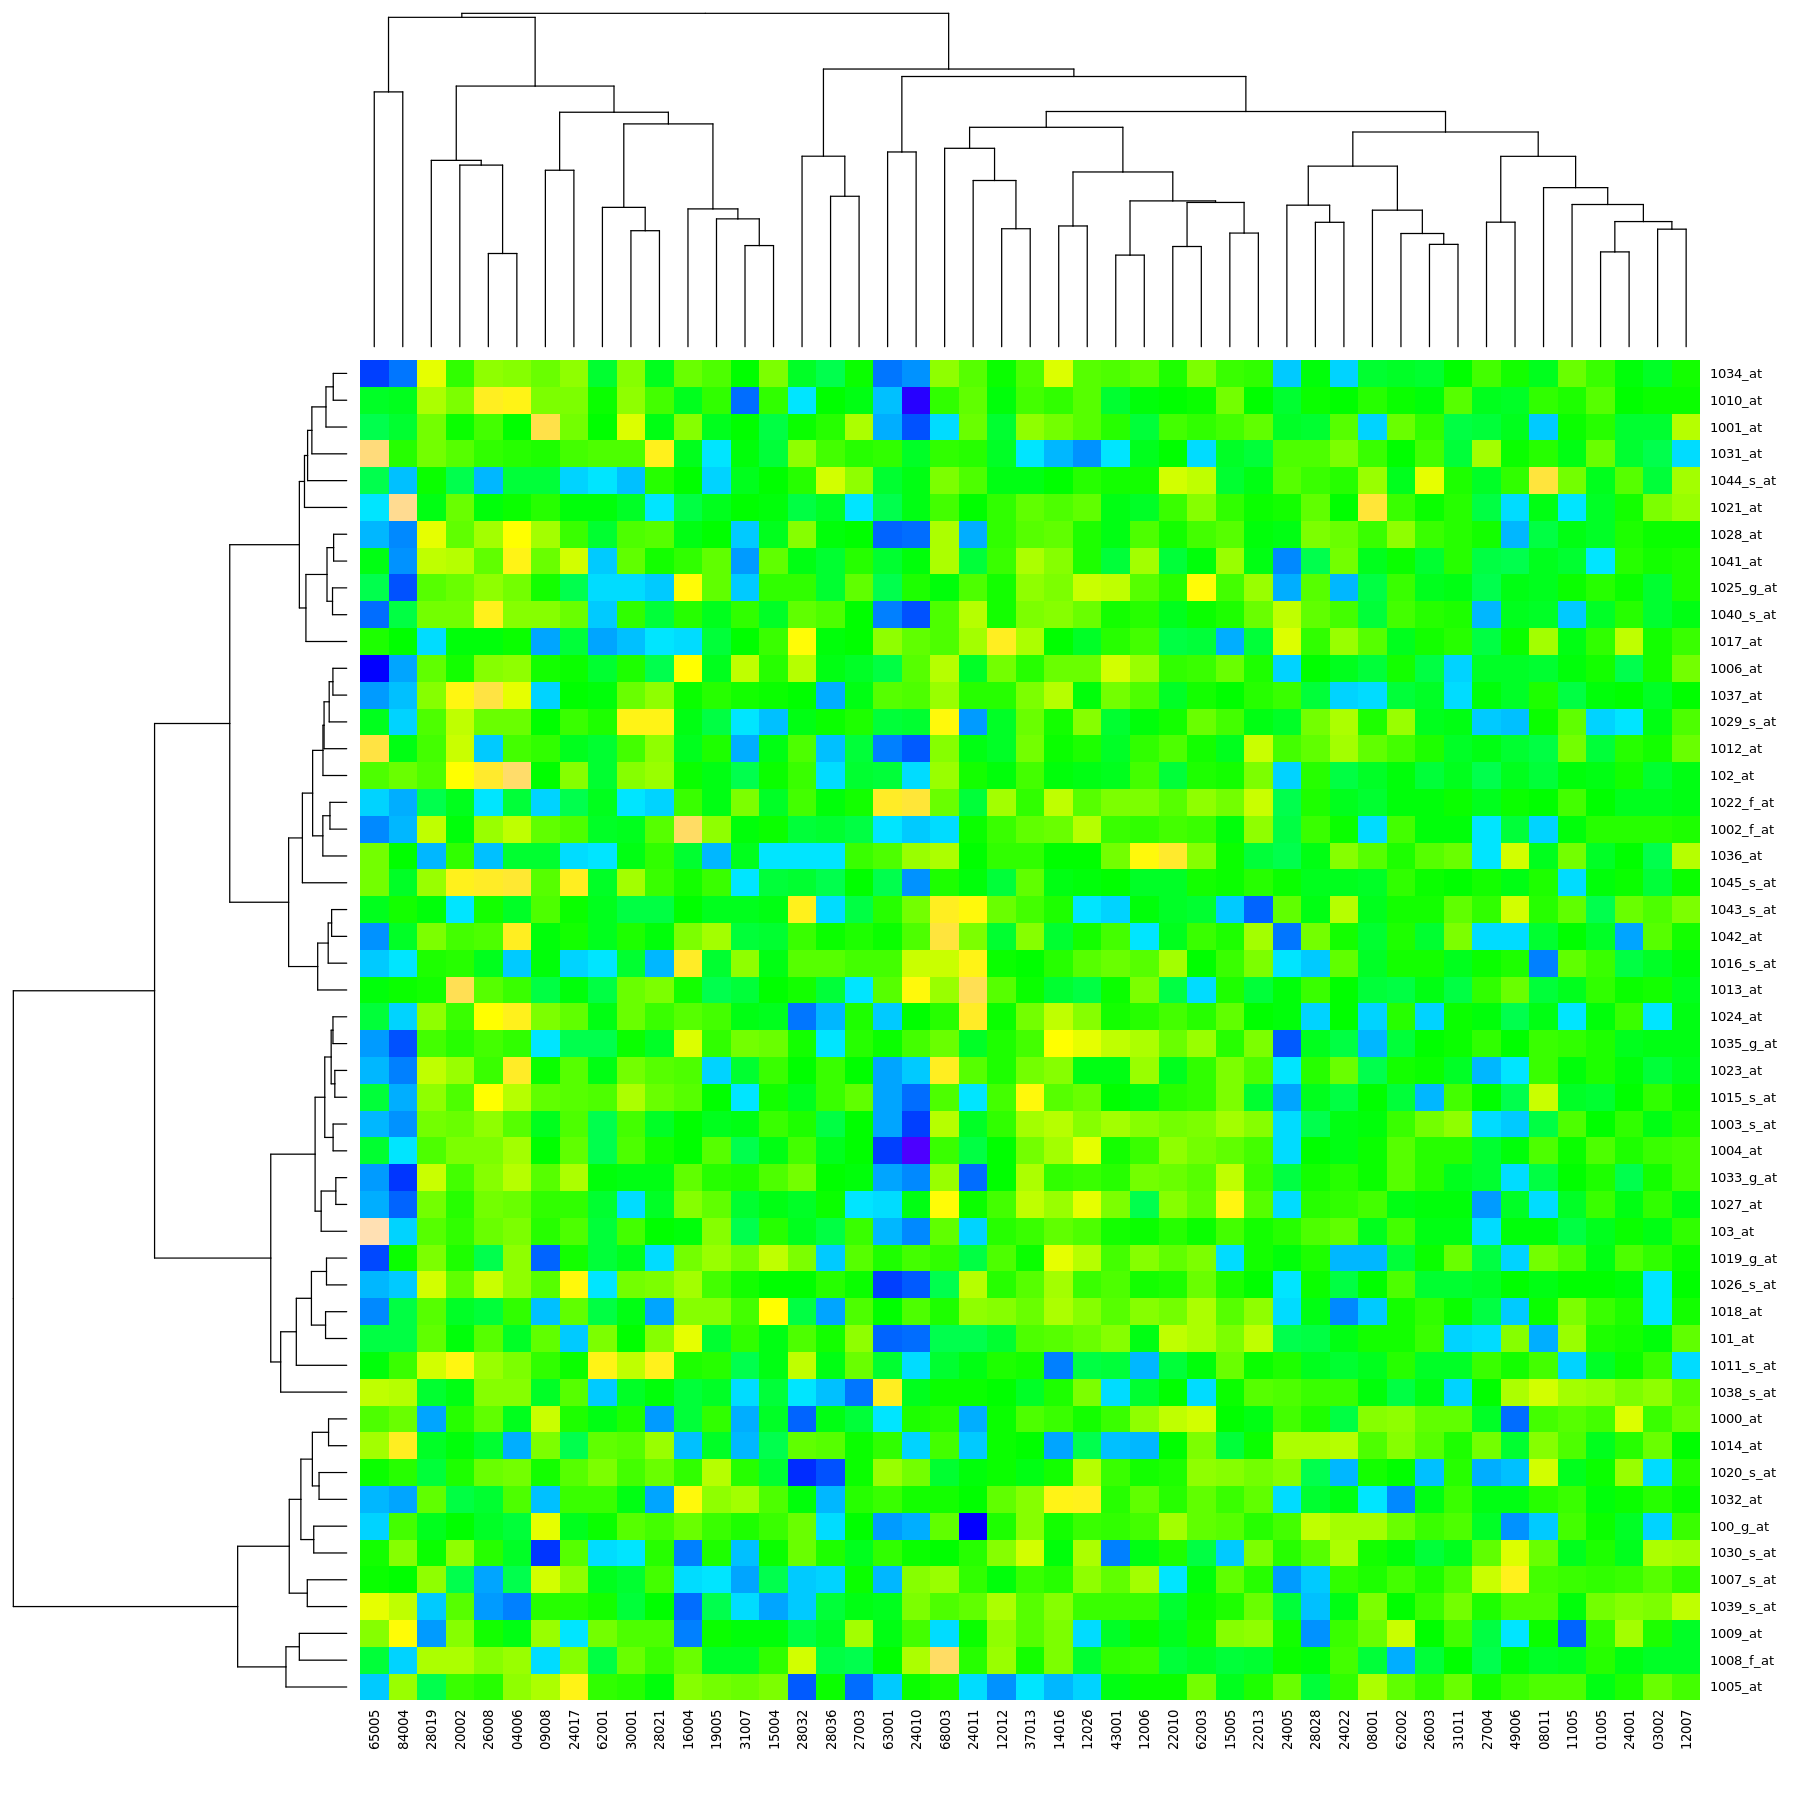

In [4]:
heatmap(exprs(eset[1:50,]), col=topo.colors(100))

**QUESTION**: Examine the heatmap.  Based on the level of expression
variation *within a cluster* compared with the difference
you see when comparing it vs. a different cluster,
how reliable do you think this clustering is?

**ANSWER**: Within a cluster, it seems that most of the time, variation isn't much. Among different clusters, there is much more variation. But even then, it does seem like variation within a cluster is still relatively pretty high, much higher than normal (multiple instances where blue and yellow are clustered), so in my opinion, it's not *that* relabile of a clustering.

### Validating our clustering?

One way to validate a clustering is to compare it with
independent information about the samples.  The microarray
dataset comes with multiple "phenoData" variables describing
the individual samples.  You can view the list of data
available for the ALL dataset as follows:

In [5]:
ALL
phenoData(ALL)
varMetadata(phenoData(ALL))

ExpressionSet (storageMode: lockedEnvironment)
assayData: 12625 features, 128 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: 01005 01010 ... LAL4 (128 total)
  varLabels: cod diagnosis ... date last seen (21 total)
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
  pubMedIds: 14684422 16243790 
Annotation: hgu95av2 

An object of class 'AnnotatedDataFrame'
  sampleNames: 01005 01010 ... LAL4 (128 total)
  varLabels: cod diagnosis ... date last seen (21 total)
  varMetadata: labelDescription

,labelDescription
,<chr>
cod,Patient ID
diagnosis,Date of diagnosis
sex,Gender of the patient
age,Age of the patient at entry
BT,does the patient have B-cell or T-cell ALL
remission,"Complete remission(CR), refractory(REF) or NA. Derived from CR"
CR,Original remisson data
date.cr,Date complete remission if achieved
t(4;11),did the patient have t(4;11) translocation. Derived from citog


### Comparing with clinical outcomes

For example, let's compare how well the clustering predicts 
the clinical outcome, as given by the ``remission`` variable.
We can project the clinical outcome on top of the heatmap,
as follows, coding *refractory* cases (treatment failed) in red,
vs. *complete remission* (patient cured) in blue::

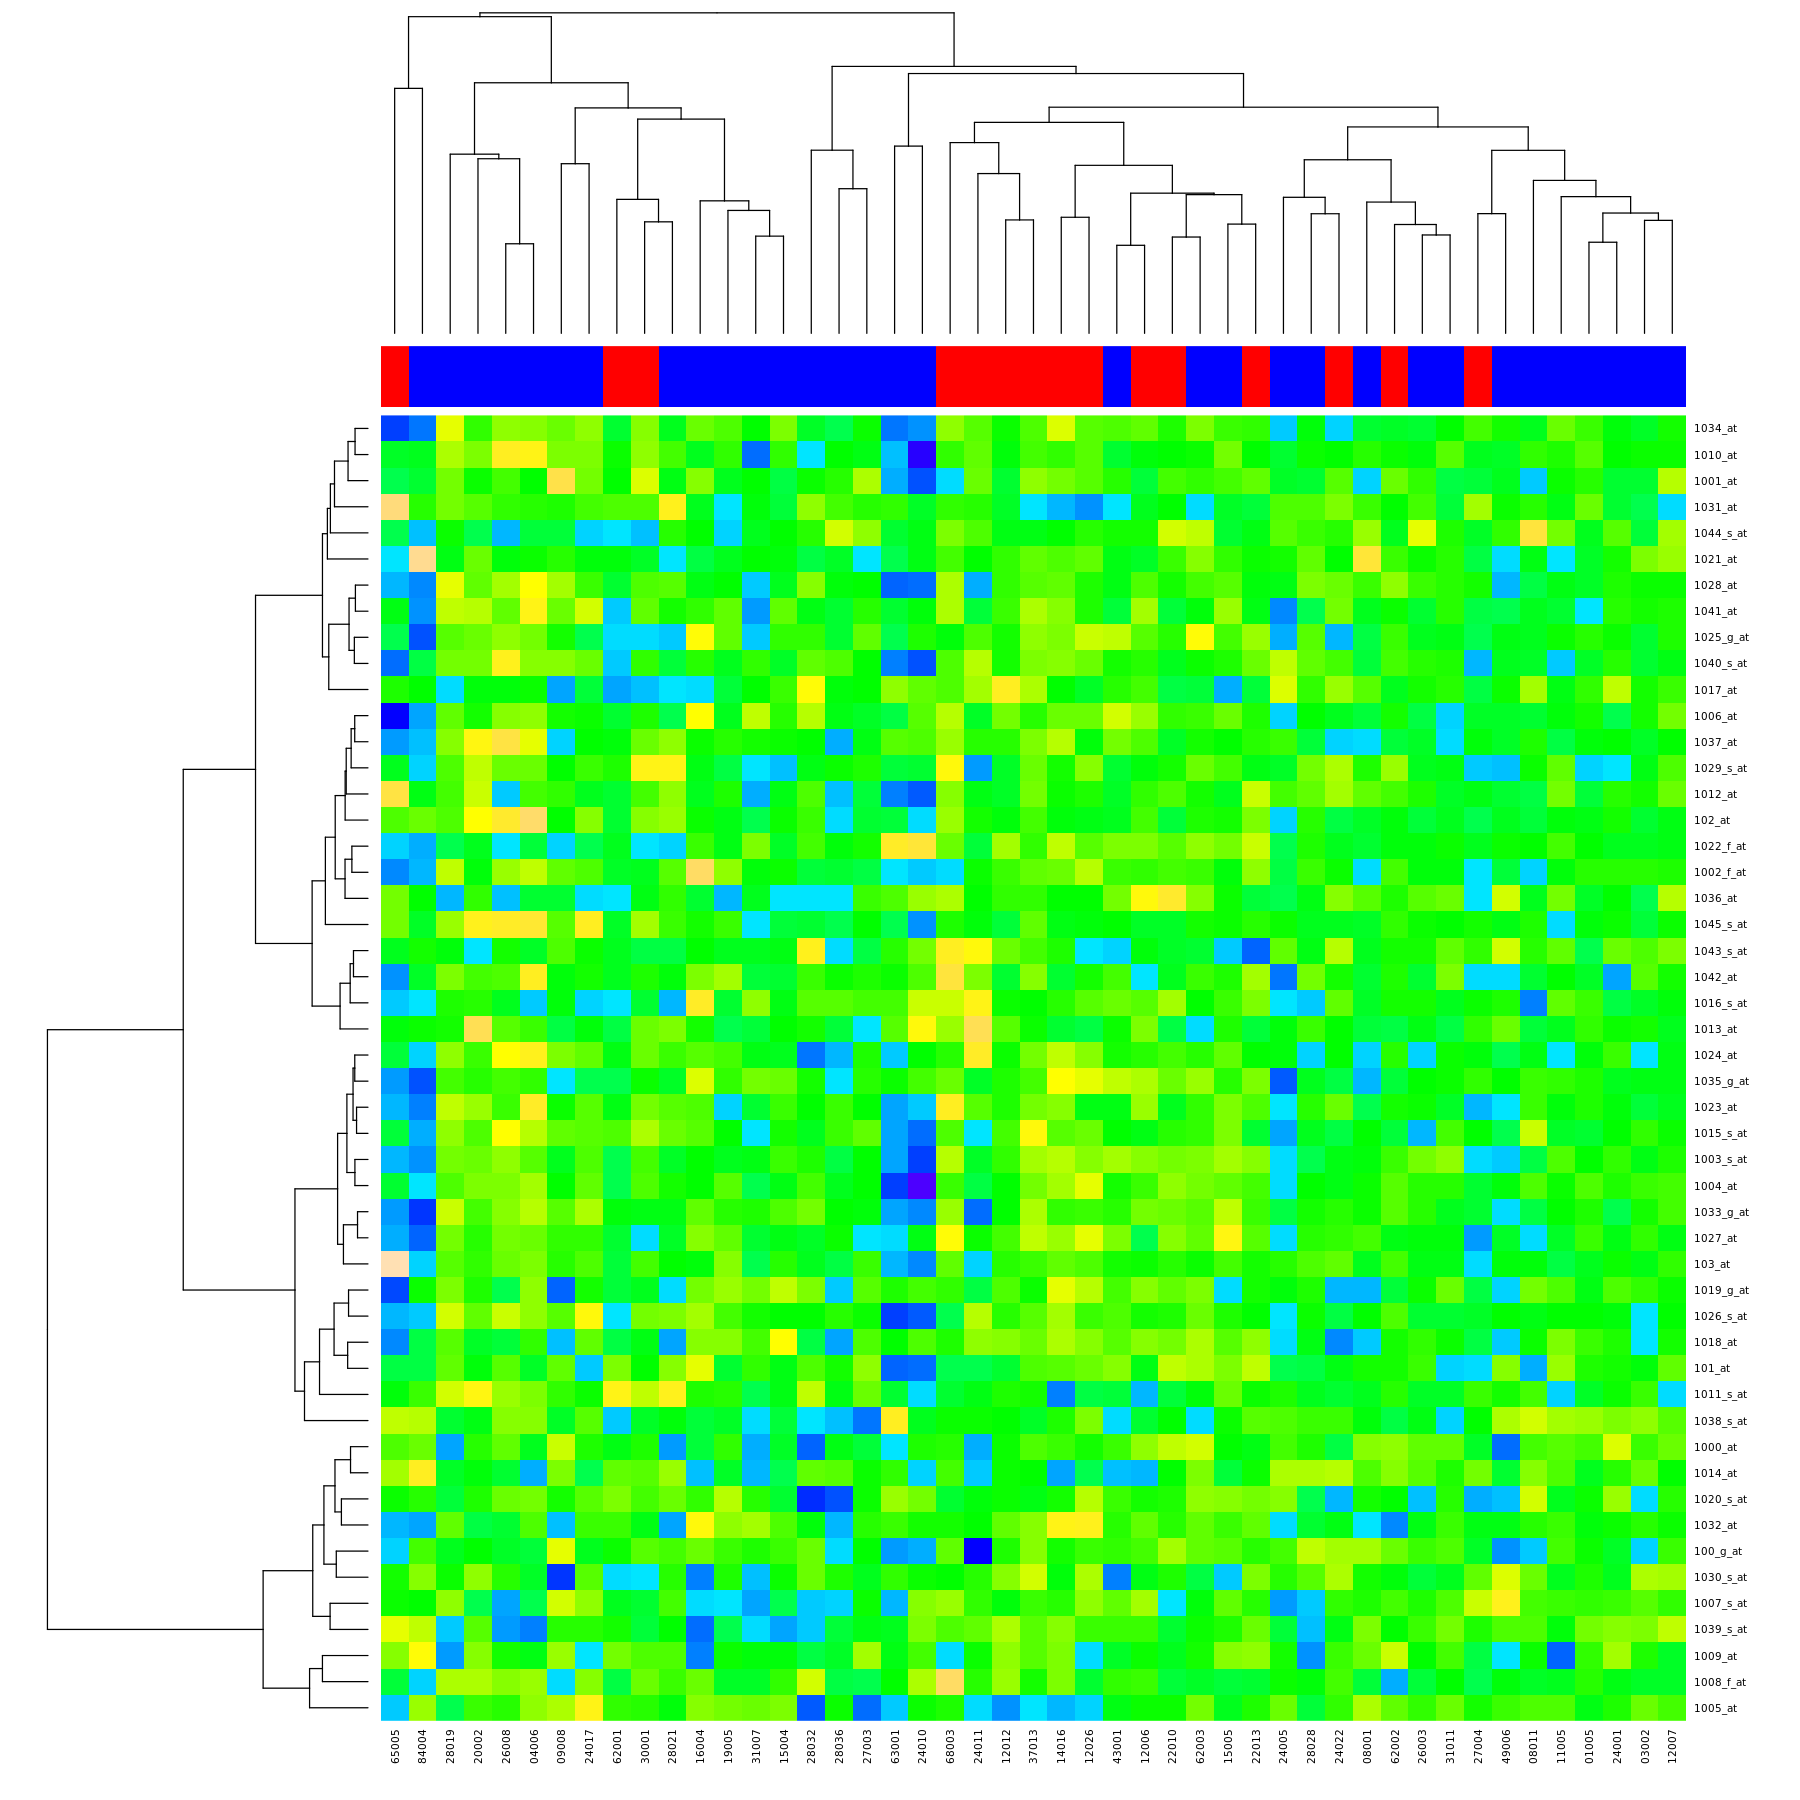

In [6]:
color.map <- function(remission) { if (remission=="REF"
             || is.na(remission)==TRUE) "#FF0000" else "#0000FF" }
patientcolors <- unlist(lapply(eset$remission, color.map))
heatmap(exprs(eset[1:50,]), col=topo.colors(100),
                  ColSideColors=patientcolors)

**QUESTION**: How well does this clustering compare with the clinical
outcome?  Does this make you more or less confident in this
clustering?

**ANSWER**: This clustering doesn't compare well with the clinical outcome; for instance, there is a region under a red outcome that looks similar to that under a blue outcome. This makes me less confident in the clustering.

## Differential Gene Expression Analysis


Next, let's expand our analysis to the entire set of genes.
We begin by performing a differential gene expression
analysis, to identify genes whose expression undergoes
convincing changes in BCR/ABL
vs. ALL1/AF4 leukemias.
We do this using the ``limma`` module

In [7]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

BiocManager::install("limma")
library("limma")
f <- factor(as.character(eset$mol.biol))
design <- model.matrix(~f)
fit <- eBayes(lmFit(eset,design))

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)

Installing package(s) 'limma'

Warning message in install.packages(...):
“installation of package ‘limma’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Warning message in file.create(f.tg):
“cannot create file '/usr/local/anaconda3/lib/R/doc/html/packages.html', reason 'Permission denied'”
Warning message in make.packages.html(.Library):
“cannot update HTML package index”
Old packages: 'backports', 'broom', 'dbplyr', 'ellipsis', 'fs', 'ggtree',
  'glue', 'isoband', 'lattice', 'lubridate', 'MASS', 'modelr', 'nlme',
  'pillar', 'pkgbuild', 'ps', 'purrr', 'Rcpp', 'RCurl', 'reshape2', 'rlang',
  'S4Vectors', 'scales', 'survival', 'tibble', 'tidyr', 'tidyselect',
  'tidytree', 'tinytex', 'vctrs', 'withr', 'xfun', 'xml2'


Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA




Let's select for genes that show strong evidence of regulation.
Note that this is using a stringent multiple-testing
correction of the p-values:

In [8]:
selected  <- p.adjust(fit$p.value[, 2]) <0.05
esetSel <- eset [selected, ]

You can view a summary of the results as follows:

In [9]:
esetSel

ExpressionSet (storageMode: lockedEnvironment)
assayData: 165 features, 47 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: 01005 03002 ... 84004 (47 total)
  varLabels: cod diagnosis ... date last seen (21 total)
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
  pubMedIds: 14684422 16243790 
Annotation: hgu95av2 

**QUESTION**: How many genes appear to be undergoing convincing changes in
expression by these criteria?

**ANSWER**: It appears that there are 165 genes that are undergoing convincing changes in expression by the criteria. 

## Pathway Analysis


Next, let's see if some pathways are over-represented
in our regulated genes.  We do this using the ``GOstats``
module, which uses the hypergeometric distribution (as
discussed in lecture) to assess whether the set
of genes shows a strikingly non-random representation
of pathways.  To do this, we first have to retrieve
the gene annotation information for this microarray design
(Affymetrix ``hgu95av2``):

In [10]:
BiocManager::install("hgu95av2.db")
library("hgu95av2.db")
entrezUniverse <- unlist(mget(featureNames(eset), hgu95av2ENTREZID))
selectedEntrezIds <- unlist(mget(featureNames(esetSel), hgu95av2ENTREZID))

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)

Installing package(s) 'hgu95av2.db'

Warning message in install.packages(...):
“installation of package ‘hgu95av2.db’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Warning message in file.create(f.tg):
“cannot create file '/usr/local/anaconda3/lib/R/doc/html/packages.html', reason 'Permission denied'”
Warning message in make.packages.html(.Library):
“cannot update HTML package index”
Old packages: 'backports', 'broom', 'dbplyr', 'ellipsis', 'fs', 'ggtree',
  'glue', 'isoband', 'lattice', 'lubridate', 'MASS', 'modelr', 'nlme',
  'pillar', 'pkgbuild', 'ps', 'purrr', 'Rcpp', 'RCurl', 'reshape2', 'rlang',
  'S4Vectors', 'scales', 'survival', 'tibble', 'tidyr', 'tidyselect',
  'tidytree', 'tinytex', 'vctrs', 'withr', 'xfun', 'xml2'

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRanges

Loading required package: S4Vectors


Attaching packag

Next, we perform the hypergeometric p-value analysis:

In [11]:
BiocManager::install("GOstats")
library("GOstats")
params <- new("GOHyperGParams", geneIds = selectedEntrezIds,
                      universeGeneIds = entrezUniverse,
                      annotation = "hgu95av2.db", ontology = "BP",
                      pvalueCutoff = 0.001, conditional = FALSE,
                      testDirection = "over")
hgOver <- hyperGTest(params)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)

Installing package(s) 'GOstats'

Warning message in install.packages(...):
“installation of package ‘GOstats’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Warning message in file.create(f.tg):
“cannot create file '/usr/local/anaconda3/lib/R/doc/html/packages.html', reason 'Permission denied'”
Warning message in make.packages.html(.Library):
“cannot update HTML package index”
Old packages: 'backports', 'broom', 'dbplyr', 'ellipsis', 'fs', 'ggtree',
  'glue', 'isoband', 'lattice', 'lubridate', 'MASS', 'modelr', 'nlme',
  'pillar', 'pkgbuild', 'ps', 'purrr', 'Rcpp', 'RCurl', 'reshape2', 'rlang',
  'S4Vectors', 'scales', 'survival', 'tibble', 'tidyr', 'tidyselect',
  'tidytree', 'tinytex', 'vctrs', 'withr', 'xfun', 'xml2'

Loading required package: Category

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand




We can view the results as follows:

In [12]:
hgOver
summary(hgOver)

Gene to GO BP  test for over-representation 
3631 GO BP ids tested (65 have p < 0.001)
Selected gene set size: 131 
    Gene universe size: 8172 
    Annotation package: hgu95av2 

GOBPID,Pvalue,OddsRatio,ExpCount,Count,Size,Term
<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
GO:0019221,1.731151e-06,3.282709,9.45790504,26,590,cytokine-mediated signaling pathway
GO:0071345,3.380238e-06,2.869477,13.06473324,31,815,cellular response to cytokine stimulus
GO:0006955,1.108653e-05,2.385491,21.96157611,42,1370,immune response
GO:0060333,1.160204e-05,8.651491,1.09006363,8,68,interferon-gamma-mediated signaling pathway
GO:0002484,1.591860e-05,188.437500,0.06412139,3,4,antigen processing and presentation of endogenous peptide antigen via MHC class I via ER pathway
GO:0002486,1.591860e-05,188.437500,0.06412139,3,4,"antigen processing and presentation of endogenous peptide antigen via MHC class I via ER pathway, TAP-independent"
GO:0034097,1.746085e-05,2.615716,14.15479687,31,883,response to cytokine
GO:0002476,3.932914e-05,94.207031,0.08015174,3,5,antigen processing and presentation of endogenous peptide antigen via MHC class Ib
GO:0071310,7.369643e-05,2.075923,30.34544787,50,1893,cellular response to organic substance


**QUESTION**: How many pathways appear to appear differentially
expressed in BCR/ABL vs. ALL1/AF4 tumors?

**ANSWER**: There appears to be 65 pathways that appear differentially expressed in BCR/ABL vs ALL1/AF4 tumors.

**QUESTION**: Look up basic information about ALL leukemia on the web.
Based on your reading, select five example pathways
that do appear to be associated with the cell types
involved in ALL.

**ANSWER**: Five example pathways that appear associated with the cell types involved in ALL: cell proliferation, regulation of DNA methylation, positive regulation of leukocyte cell-cell adhesion, regulation of lymphocyte activation, and regulation of leukocyte activation.

## Hierarchical Clustering on Regulated Genes


First let's look at the hierarchical clustering based just on
our *regulated* genes:

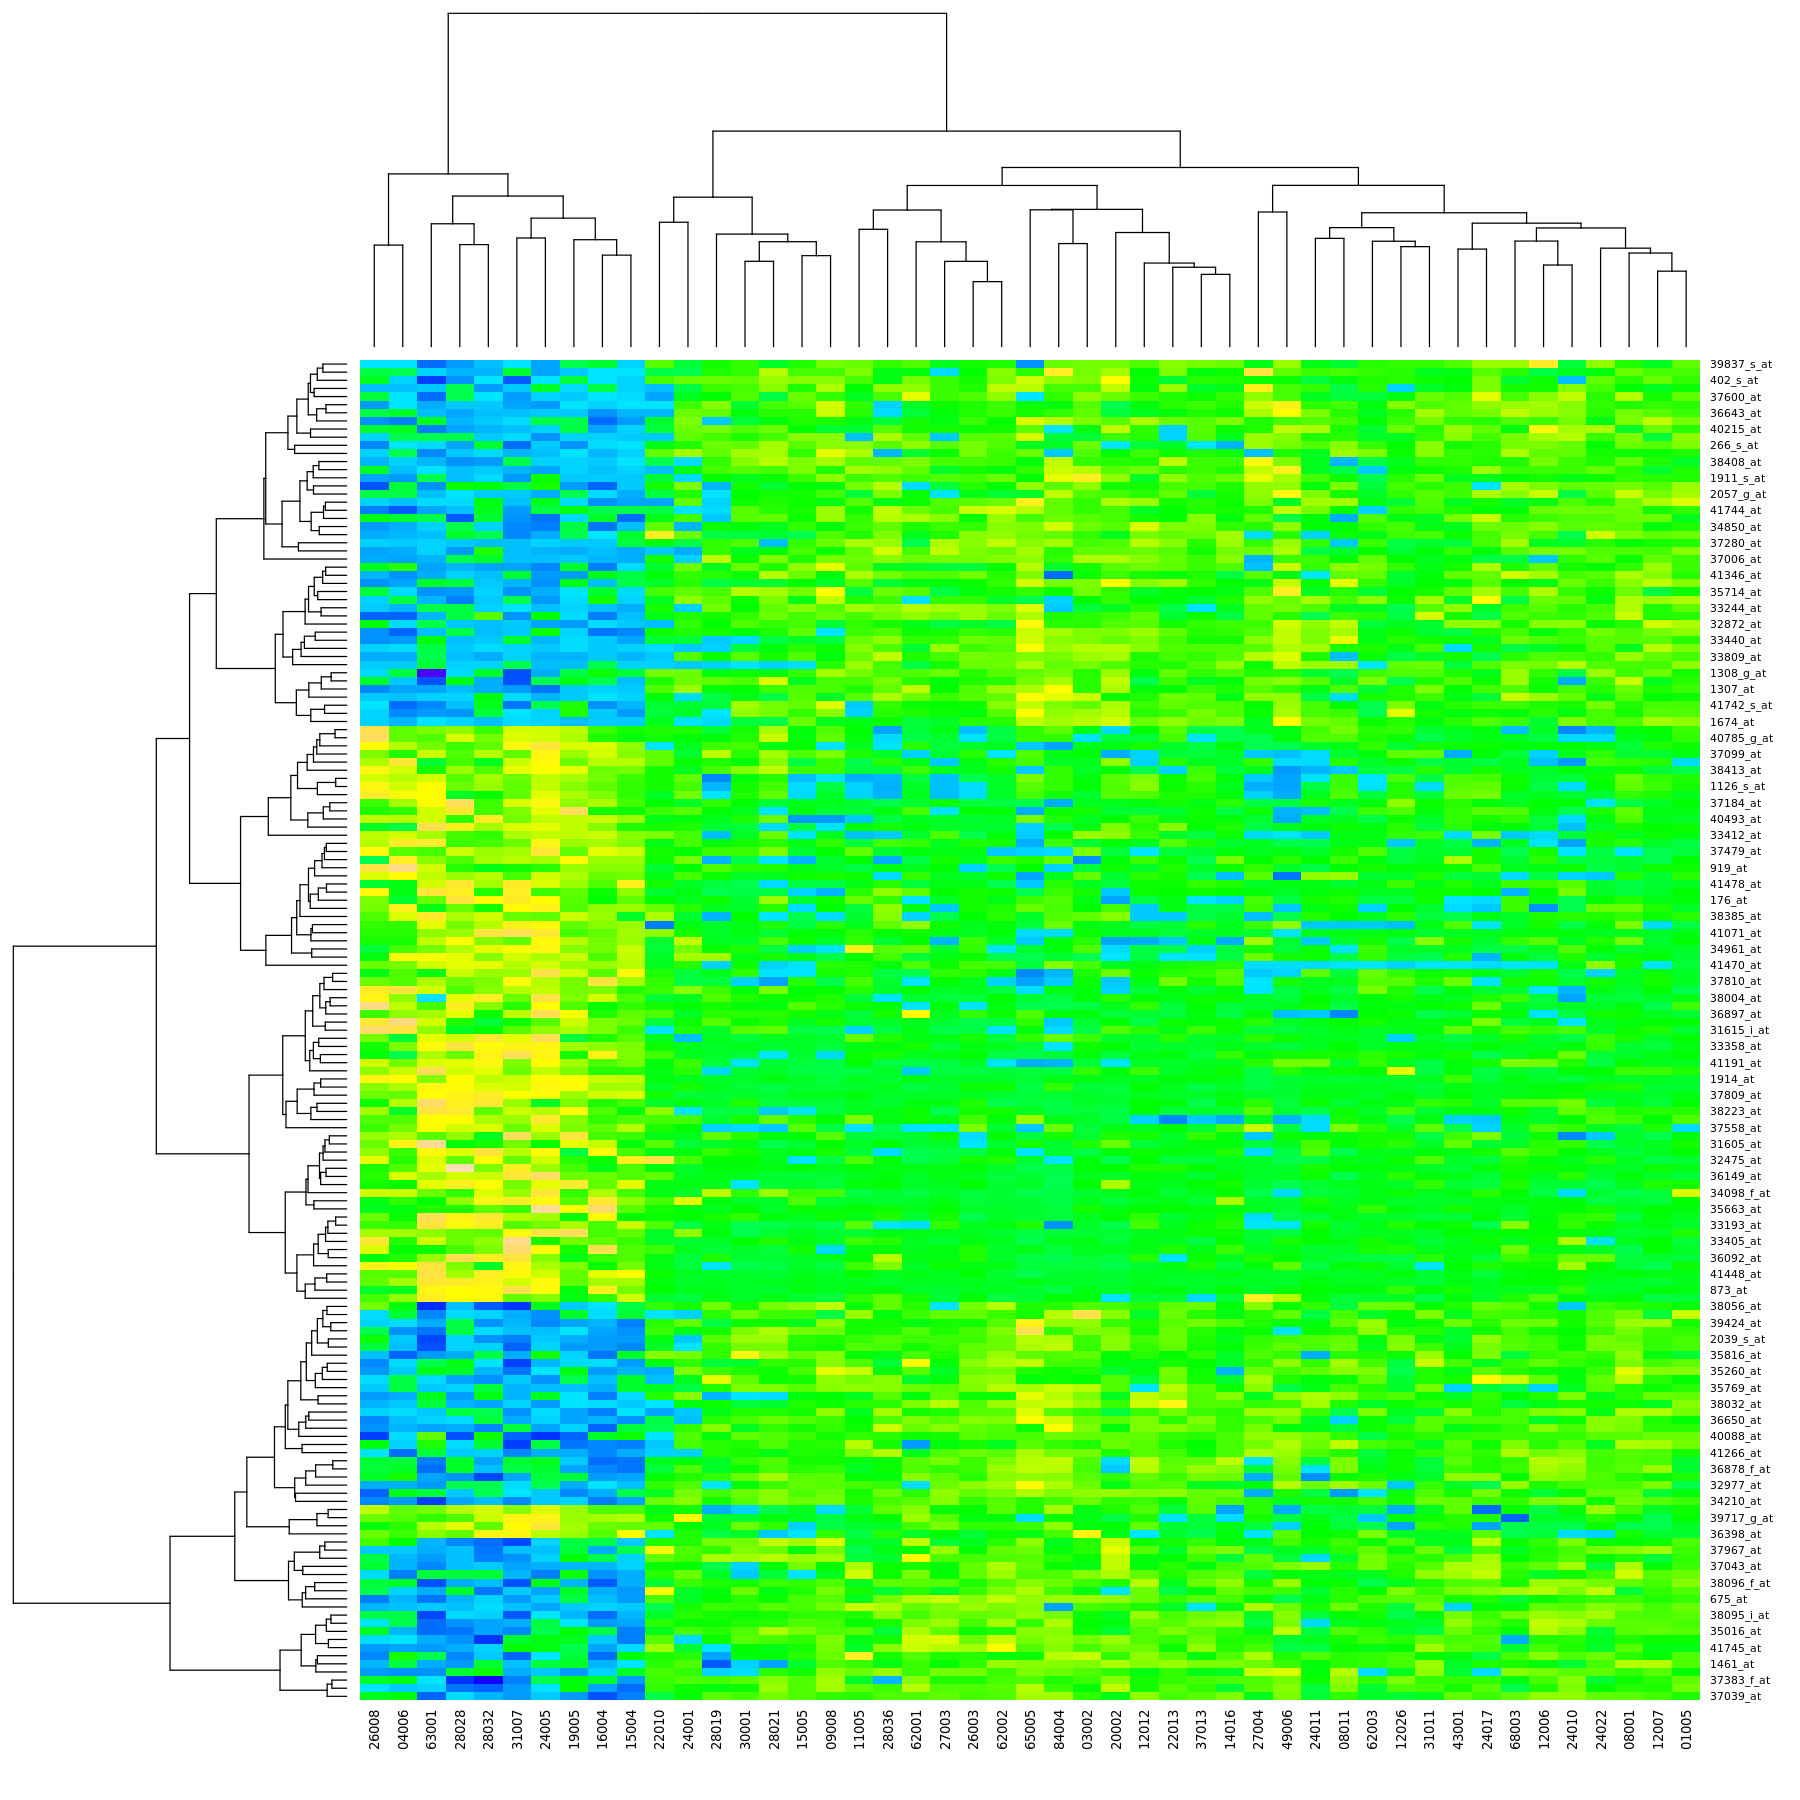

In [13]:
heatmap(exprs(esetSel), col=topo.colors(100))

**QUESTION**: Based on the heatmap, does this clustering appear to be more reliable than the first clustering?  Give specific examples in comparing the two clusterings.

**ANSWER**: Yes, this clustering appears more reliable than the first. In the first heatmap, there aren't really distinct clusters of genes that differentiate the samples too well. For example, here in this heatmap, in the first few samples, there are many samples that have the same, specific genes expressed at low levels.

**QUESTION**: Are there any features of the gene clustering that
seem anomalous based on the heatmap?  (i.e. clustering
together sets of genes that appear to have rather different
gene expression profiles)  What about for the sample 
clustering?

**ANSWER**: Yes, the top most primary subtree is has one half that is much different from the other (one half is primarily blue, while the other is yellow). Sample clustering doesn't really have any anomalous features.

## Clinical comparison 2

Once again, let's try to validate our clustering
results vs. independent clinical information for the samples.
First, compare
against the clinical outcomes (red, treatment failed;
blue, complete remission):

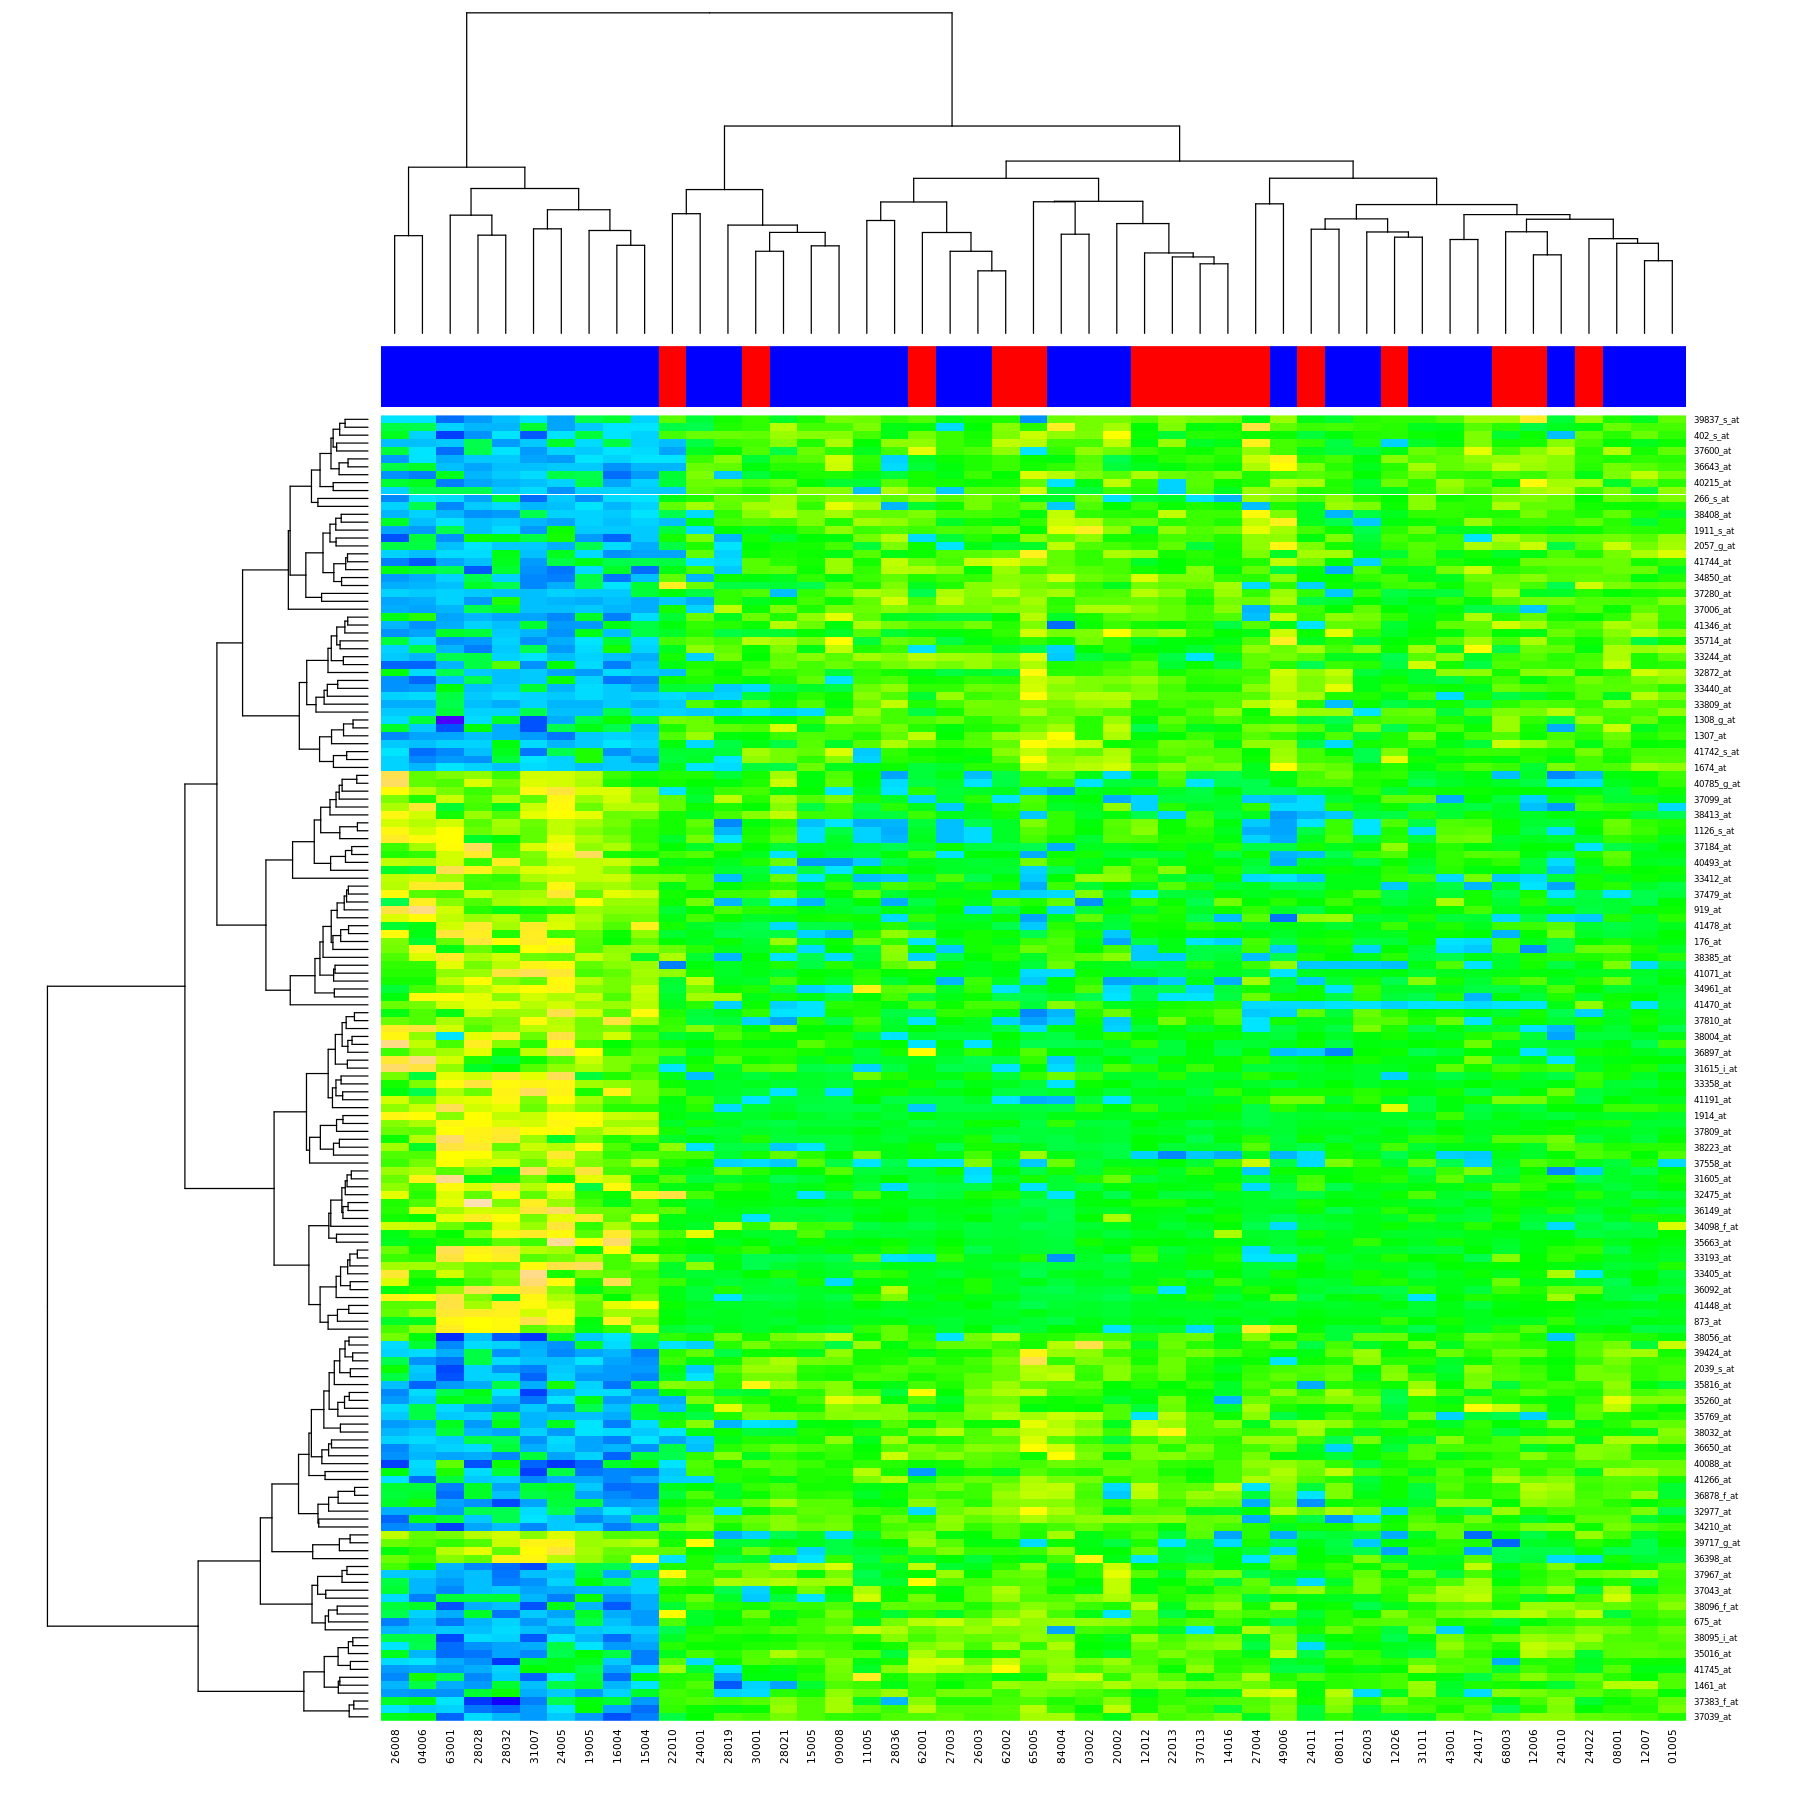

In [14]:
patientcolors <- unlist(lapply(esetSel$remission, color.map))
heatmap(exprs(esetSel), col=topo.colors(100),
                   ColSideColors=patientcolors)

**QUESTION**: Does the clustering appear to be predictive of the 
clinical outcome?  Explain in detail.  Does this
result make you more or less confident in the clustering?

**ANSWER**: Not really, it may seem like it at first, since there's the first chunk of complete remission samples that have very similar gene expression patterns, but there are many other remission samples that have different expression from that chunk as you go leftwards. This makes me less confident in the clustering.

## Comparison with molecular classification

Of course, there are additional data about these tumor
samples that we can compare with.
Let's try comparing the clustering vs. the underlying molecular
biology classification of the tumors (RED for ALL1/AF4 tumors,
blue for BCR/ABL tumors):

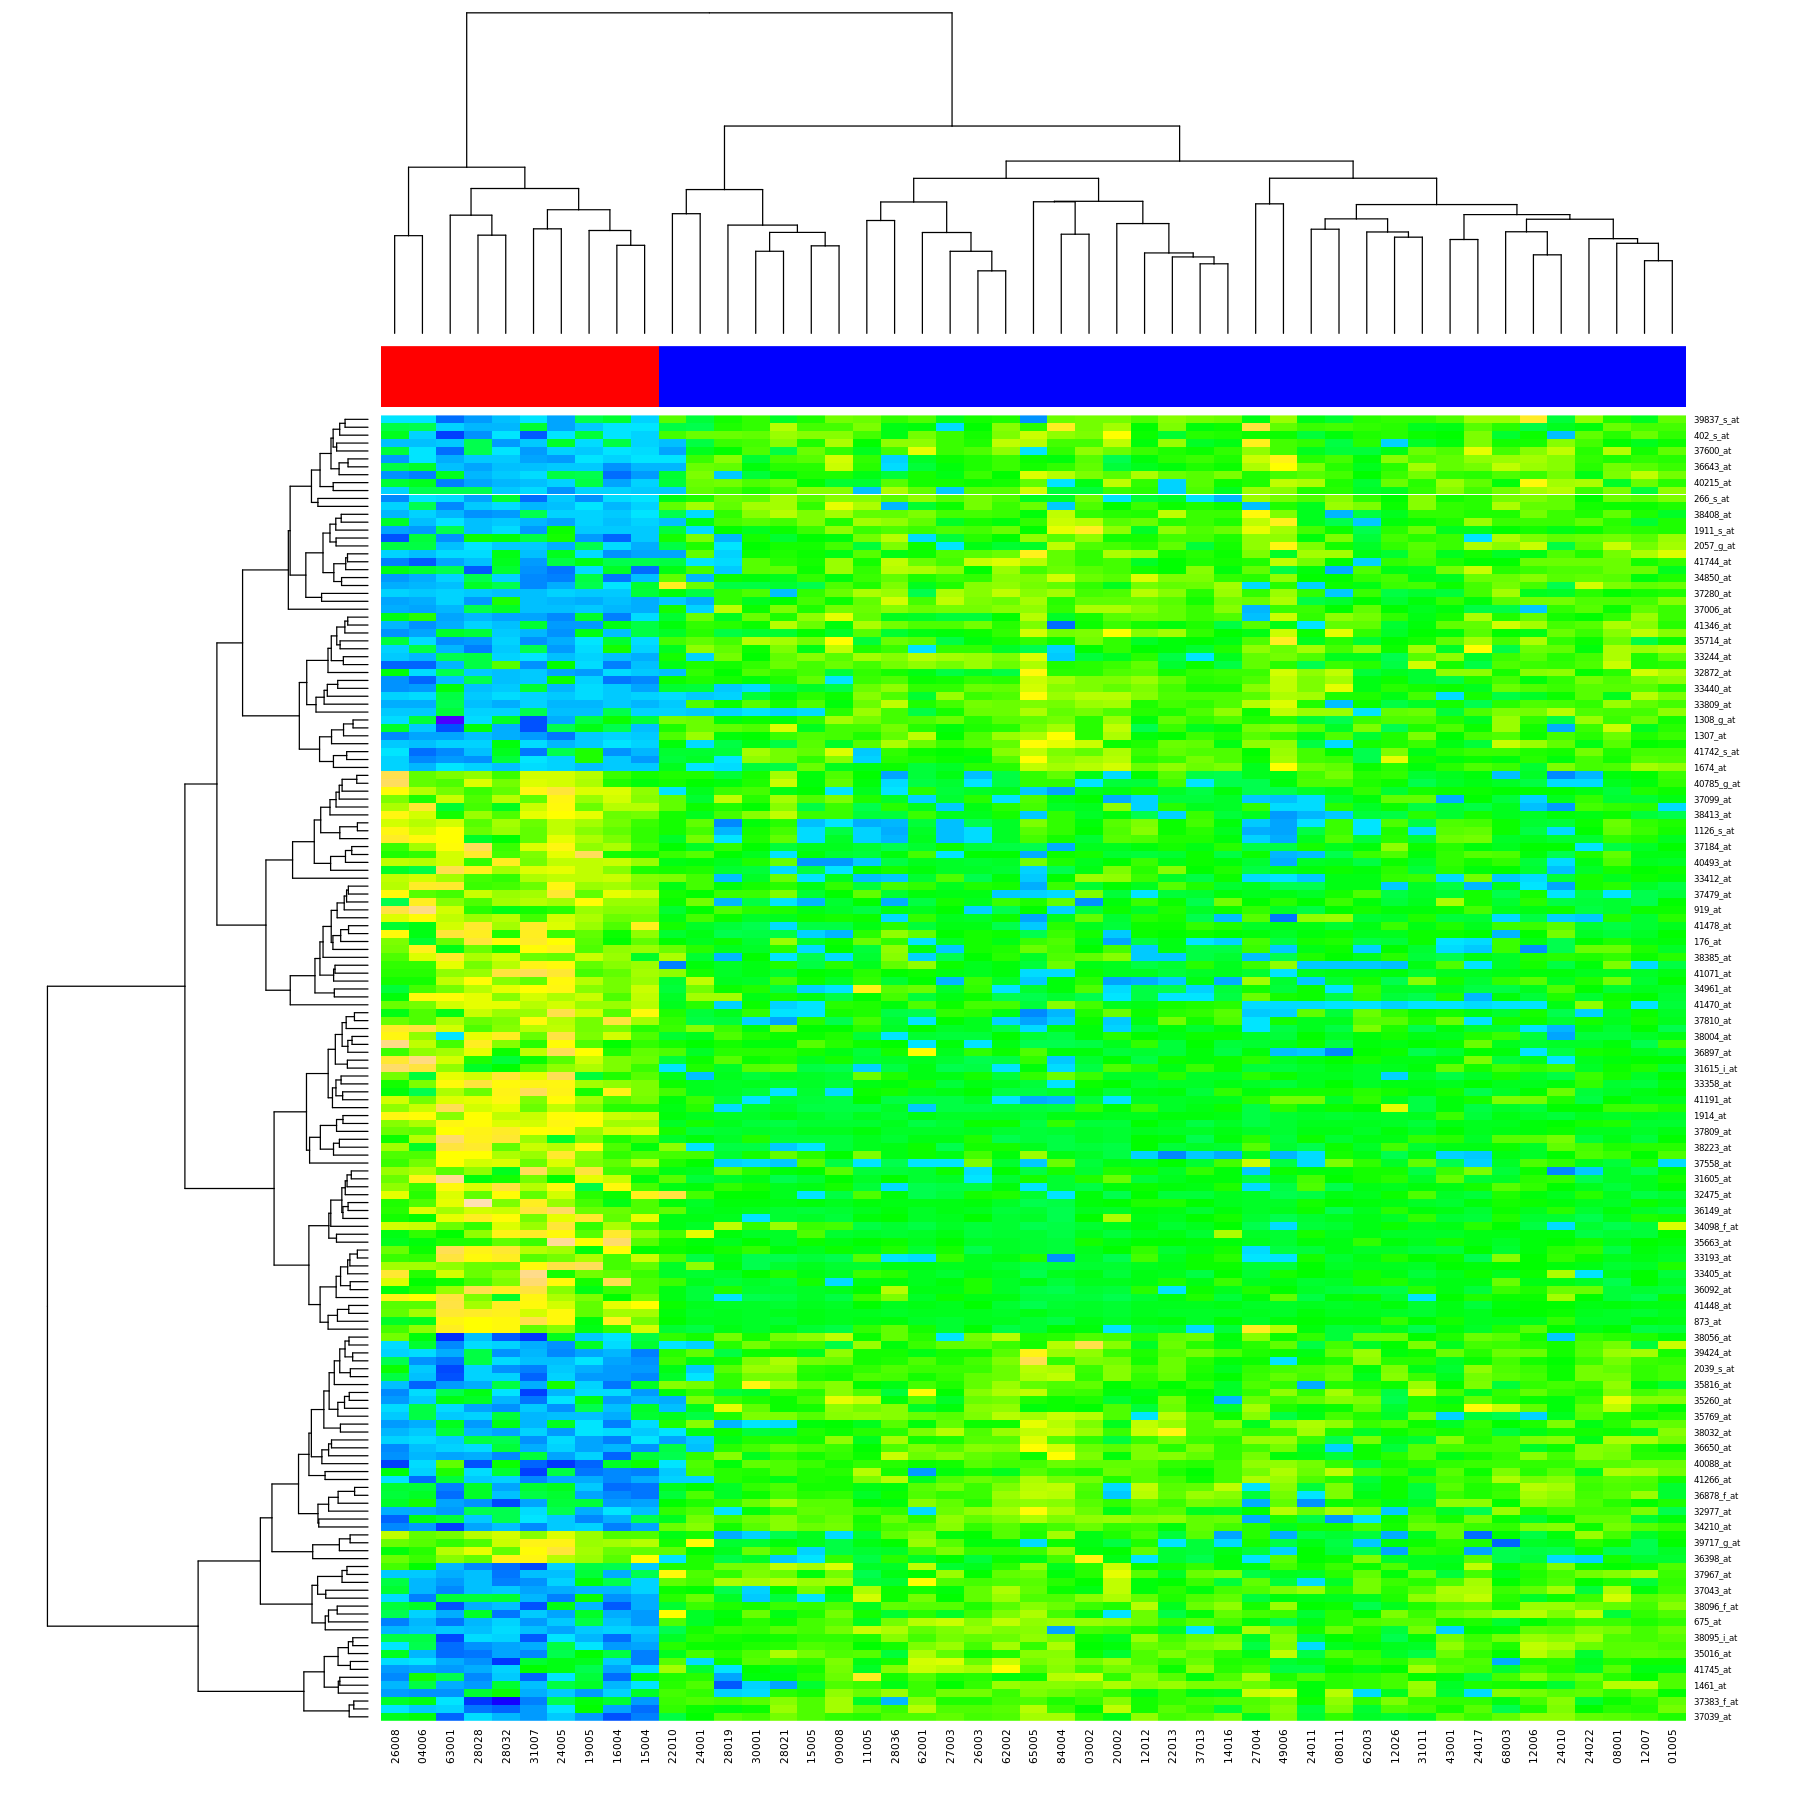

In [15]:
color.map2 <- function(mol.biol) {
             if (mol.biol=="ALL1/AF4") "#FF0000" else "#0000FF" }
patientcolors2 <- unlist(lapply(esetSel$mol.biol, color.map2))
heatmap(exprs(esetSel), col=topo.colors(100),
                   ColSideColors=patientcolors2)

**QUESTION**: Does the clustering appear to be predictive of the 
tumor subtype?  Explain in detail.  Does this
result make you more or less confident in the clustering?

**ANSWER**: Yes, as seen from the heatmap, there is a distinct difference in how certain genes are regulated between the ALL1/AF4 tumors and the BCR/ABL tumors, such that for ALL1/AF4, there are distinct chunks of genes that are more blue, while in the BCR/ABL, they are more green. The same goes for areas that are more yellow and green in ALL1/AF4, but are more blue and green in BCR/ABL. This result makes me more confident in the clustering.